<a href="https://colab.research.google.com/github/KevinFan9729/Generative-Adversarial-Network-Image/blob/master/GAN_Celebrity_Face_Generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:
#from __future__ import print_function
import argparse
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

#Setting the seeds of random number generator and torch for reproducibility
seed = 999
random.seed(seed)
torch.manual_seed(seed)

In [47]:
import os
dataRoot=os.path.abspath("/content/drive/My Drive/celeba/")
os.chdir(dataRoot)
print("the current directory is %s" % dataRoot)

the current directory is /content/drive/My Drive/celeba


In [0]:
##uploading data to the web drive. Only needs to be executed once
#from zipfile import ZipFile
#import zipfile
#def unzip(source_filename):
#    with zipfile.ZipFile(source_filename) as zf:
#        zf.extractall()

#fileName="img_align_celeba.zip"
#unzip(fileName)

*  **dataRoot**: the path of dataset folder
*  **wokers**: the number of worker threads for loading the data with the data loader
*   **batchSize**: the batch size used in tranning
*   **imageSize**: the size of the images used for tranning
*   **nc**: the number of color channel of the image 
*   **nz**: the length of laten vector
*   **ngf**: relates to the depth of feature maps carried through the generator
*   **ndf**: sets the depth of freature mpas propagated through the discriminator 


In [0]:
workers=2
batchSize=128
imageSize=64 #64*64 image
nc=3 #3 channels RGB image
nz=100 #size of the latent vector. The sizer of the generator input
numEpochs=5
lr=0.0002
beta1=0.5
ngpu=1 #number of GPUs available. Set this to 0 for cpu

In [59]:
#dataset creation 
dataset=dset.ImageFolder(root=dataRoot,transform=transforms.Compose([transforms.Resize(imageSize),
                                                                     transforms.CenterCrop(imageSize),
                                                                     transforms.ToTensor(),
                                                                     transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))]))
#Note, transforms.Normalize((mean),(std)) needs the same number of inputs as the target image/data channel number
#In this case we are dealing with 3*64*64 RGB images. So the number of channels is 3

print("The Summary of dataset:\n")
dataset

The Summary of dataset:



Dataset ImageFolder
    Number of datapoints: 44020
    Root location: /content/drive/My Drive/celeba
    StandardTransform
Transform: Compose(
               Resize(size=64, interpolation=PIL.Image.BILINEAR)
               CenterCrop(size=(64, 64))
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

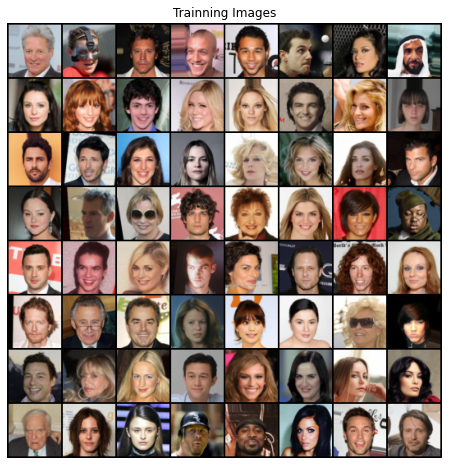

In [183]:
#dataloader Creation
dataloader=torch.utils.data.DataLoader(dataset=dataset,batch_size=batchSize,shuffle=True,num_workers=workers)
#determine which device to run
device=torch.device("cuda:0" if (torch.cuda.is_available() and ngpu>0)else "cpu")#GPU 0

real_batch=next(iter(dataloader))
plt.figure(figsize=(8,8))#8*8 new figure
plt.axis("off")
plt.title("Trainning Images")
plt.imshow(X=np.transpose(vutils.make_grid(tensor=real_batch[0][64:].to(device),padding=2,normalize=True).cpu(),(1,2,0)))#X=(M, N, 3): an image with RGB values (0-1 float or 0-255 int).

In [0]:
def weights_init(m):
  classname=m.__class__.__name__
  if classname.find('Conv')!=-1:
    nn.init.normal_(m.weight.data,0.0,0.02 )
  elif classname.find('BatchNorm')!=-1:
    nn.init.normal_(m.weight.data,1.0,0.02 )
    nn.init.constant_(m.bias.data,0)